In [3]:
# %pip install flax
# %pip install git+https://github.com/probml/rebayes.git
# %pip install dynamax
# %pip install optax
# %pip install tqdm
# %pip install jax-tqdm
# %pip install augly
# %pip install bayesian-optimization

# Split-MNIST Classification Showdown

## 0. Imports and Load Dataset

In [4]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree
import torchvision
import optax

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [5]:
from demos.showdown import hparam_tune_ekf as hp_ekf
from demos.showdown import hparam_tune_lofi as hp_lofi

In [6]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [7]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [10]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
images = np.array(mnist_train.data) / 255.0
labels = mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root='./data', train=False)
images_test = np.array(mnist_test.data) / 255.0
labels_test = mnist_test.targets

train = (images, labels)
test = (images_test, labels_test)

In [11]:
X_train, y_train = jnp.expand_dims(jnp.expand_dims(jnp.array(images), -1), 1), jnp.array(labels.ravel()).astype(float)
X_test, y_test = jnp.expand_dims(jnp.expand_dims(jnp.array(images_test), -1), 1), jnp.array(labels_test.ravel()).astype(float)

Generate the Split-MNIST Dataset

In [12]:
train_set_by_digit_pair, test_set_by_digit_pair = {}, {}

for i in range(10//2):
    curr_pair = (2*i, 2*i+1)
    
    # Train set
    train_indx = (y_train == 2*i) | (y_train == 2*i+1)
    train_set_by_digit_pair[str(2*i)+str(2*i+1)] = (X_train[train_indx], y_train[train_indx]-2*i)

    # Test set
    test_indx = (y_test == 2*i) | (y_test == 2*i+1)
    test_set_by_digit_pair[str(2*i)+str(2*i+1)] = (X_test[test_indx], y_test[test_indx]-2*i)

Callback function to evaluate NLL

In [13]:
def nll_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
    nll = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test))
    
    res = {
        "test": nll,
    }
    return res

In [14]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(jit(apply_fn), (None, 0))(bel.mean, X_test).squeeze()
    nll_test = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(logits, y_test))
    
    # One-step-ahead NLL
    nll_ose = jnp.mean(jit(optax.sigmoid_binary_cross_entropy)(y.squeeze(), pred.mean.squeeze()))
    
    res = {
        "nll_test": nll_test,
        "nll_ose": nll_ose,
    }
    return res

# 1. Model Setup

In [15]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
key = jr.PRNGKey(1)
dim_out = 1
dim_in = (28, 28, 1)
model = MLP(dim_out, activation=nn.elu)
params = model.init(key, jnp.ones((1, *dim_in)))
flat_params, unflatten_fn = ravel_pytree(params)
n_params = len(flat_params)
print(f'flat_params.shape: {flat_params.shape}')

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

mlp_apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

flat_params.shape: (16141,)


In [16]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

key = jr.PRNGKey(0)
cnn_model = CNN()
cnn_params = cnn_model.init(key, jnp.ones((1, 28, 28, 1)))
cnn_flat_params, cnn_unflatten_fn = ravel_pytree(cnn_params)
print(f'flat_params.shape: {cnn_flat_params.shape}')

cnn_apply_fn = partial(apply, model=cnn_model, unflatten_fn=cnn_unflatten_fn)

flat_params.shape: (420481,)


In [17]:
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(mlp_apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

# 2. FCEKF

## 2.1 Digits (0 & 1) and (2 & 3) (Hyperparams Tuning)

In [18]:
n_warmup_01 = 2_000
n_warmup_23 = 200

X_01_train, y_01_train = train_set_by_digit_pair['01']
X_23_train, y_23_train = train_set_by_digit_pair['23']

X_01_test, y_01_test = test_set_by_digit_pair['01']
X_23_test, y_23_test = test_set_by_digit_pair['23']

X_01_warmup, y_01_warmup = X_01_train[:n_warmup_01], y_01_train[:n_warmup_01]
X_02_warmup, y_02_warmup = X_23_train[:n_warmup_23], y_23_train[:n_warmup_23]

warmup_train = (jnp.concatenate([X_01_warmup, X_02_warmup]), jnp.concatenate([y_01_warmup, y_02_warmup]))
warmup_test = (jnp.concatenate([X_01_test[:n_warmup_23], X_23_test[:n_warmup_01]]), 
                jnp.concatenate([y_01_test[:n_warmup_23], y_23_test[:n_warmup_01]]))

In [79]:
pbounds = {
    "log_init_cov": (-5.0, 0.0),
    "dynamics_weights": (0.9, 1.0),
}

In [80]:
fcekf_optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, nll_callback, 'fcekf',
    emission_mean_function, emission_cov_function
)

In [81]:
%%time
fcekf_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.309    | 0.9917    | -2.057    |
| 2         | -0.6944   | 0.9265    | -1.084    |
| 3         | -0.2623   | 0.9918    | -0.8632   |
| 4         | -0.6932   | 0.9728    | -3.698    |
| 5         | -0.6768   | 0.9912    | -3.696    |
| 6         | -0.6932   | 0.9766    | -3.692    |
| 7         | -0.6932   | 0.9122    | -3.07     |
| 8         | -0.6932   | 0.984     | -3.609    |
| 9         | -0.6936   | 0.907     | -1.834    |
| 10        | -0.6932   | 0.9585    | -2.094    |
| 11        | -0.1791   | 0.9993    | -0.831    |
| 12        | -0.4644   | 0.9506    | -0.8121   |
| 13        | -0.2552   | 0.9933    | -0.864    |
| 14        | -0.1758   | 0.9994    | -2.002    |
| 15        | -0.2333   | 0.9969    | -0.7329   |
| 16        | -124.9    | 1.0       | -0.6205   |
| 17        | -0.6932   | 0.9418    | -3.292    |
| 18        | -0.1685   | 1.0       | -2.874    |


In [21]:
%%time
fcekf_optimizer.maximize(
    init_points=20,
    n_iter=20,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.6934   | 0.9169    | -2.057    |
| 2         | -0.6957   | 0.265     | -1.084    |
| 3         | -0.5797   | 0.918     | -0.8632   |
| 4         | -0.6932   | 0.728     | -3.698    |
| 5         | -0.6932   | 0.9118    | -3.696    |
| 6         | -0.6932   | 0.7664    | -3.692    |
| 7         | -0.6933   | 0.1223    | -3.07     |
| 8         | -0.6932   | 0.8401    | -3.609    |
| 9         | -0.6941   | 0.06991   | -1.834    |
| 10        | -0.6937   | 0.5848    | -2.094    |
| 11        | -0.6946   | 0.6772    | -1.564    |
| 12        | -0.6932   | 0.4389    | -3.395    |
| 13        | -0.6934   | 0.5706    | -2.601    |
| 14        | -0.6969   | 0.8611    | -0.826    |
| 15        | -0.6932   | 0.1058    | -4.698    |
| 16        | -0.6961   | 0.5969    | -1.038    |
| 17        | -0.6935   | 0.2264    | -2.324    |
| 18        | -0.6933   | 0.1361    | -3.139    |


In [82]:
fcekf_hparams = hp_ekf.get_best_params(n_params, fcekf_optimizer, method="fcekf")
fcekf_hparams.pop('emission_cov_function')
fcekf_estimator = hp_ekf.build_estimator(flat_params, fcekf_hparams, None, mlp_apply_fn, method="fcekf", 
                                         emission_mean_function=emission_mean_function,
                                         emission_cov_function=emission_cov_function)

In [83]:
bel_fcekf = fcekf_estimator.init_bel()

## 2.2 Digits 4 & 5

In [84]:
X_45_train, y_45_train = train_set_by_digit_pair['45']
X_45_test, y_45_test = test_set_by_digit_pair['45']

In [85]:
test_45_kwargs = {"X_test": X_45_test, "y_test": y_45_test, "apply_fn": mlp_apply_fn}

In [86]:
bel_45_fcekf, output_45_fcekf = fcekf_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_fcekf, progress_bar=True, **test_45_kwargs
)

  0%|          | 0/11263 [00:00<?, ?it/s]

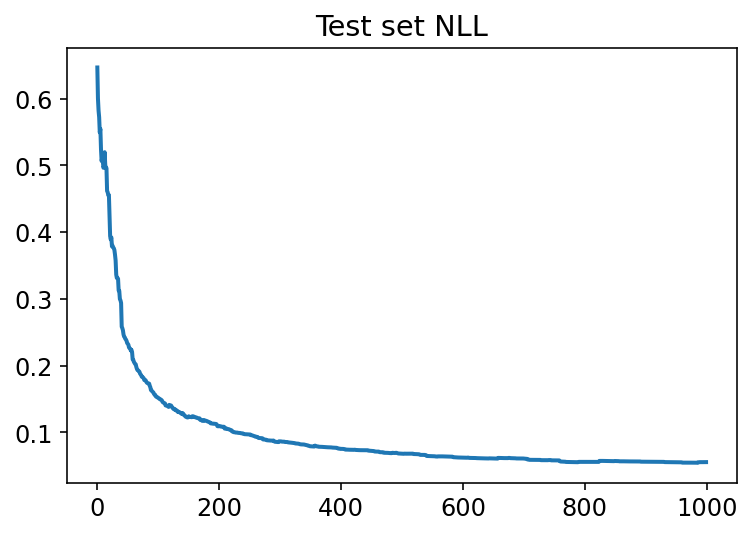

In [87]:
fig, ax = plt.subplots()
# Plot the first 1000 steps
ax.plot(output_45_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

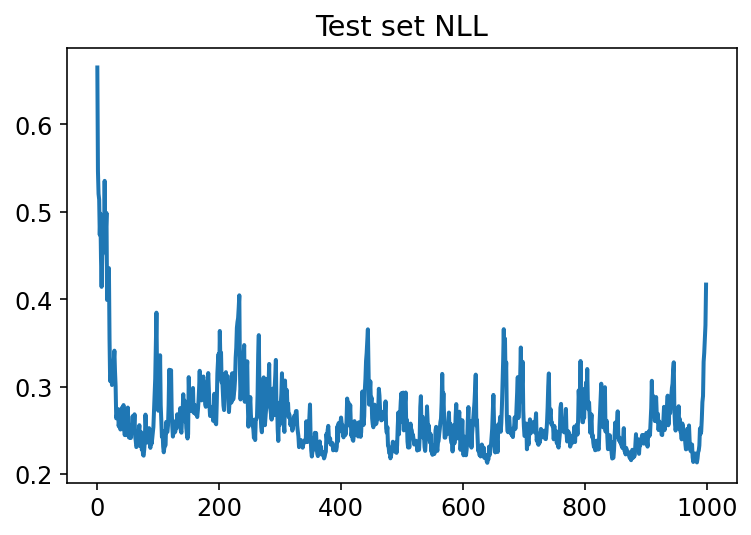

In [27]:
fig, ax = plt.subplots()
# Plot the first 1000 steps
ax.plot(output_45_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 2.3 Digits 6 & 7

In [88]:
# n_train = 1_000
X_67_train, y_67_train = train_set_by_digit_pair['67']
# X_67_train, y_67_train = X_67_train[:n_train], y_67_train[:n_train]
X_67_test, y_67_test = test_set_by_digit_pair['67']

In [89]:
test_67_kwargs = {"X_test": X_67_test, "y_test": y_67_test, "apply_fn": mlp_apply_fn}

In [90]:
bel_67_fcekf, output_67_fcekf = fcekf_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_fcekf, progress_bar=True, **test_67_kwargs
)

  0%|          | 0/12183 [00:00<?, ?it/s]

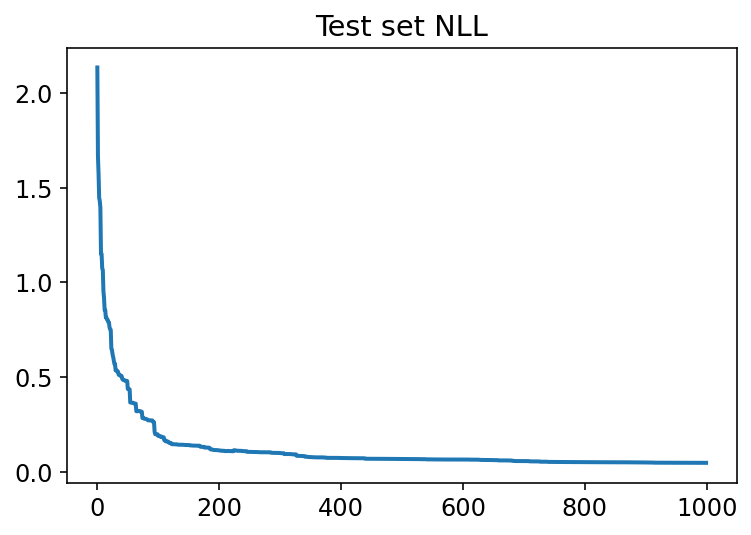

In [91]:
fig, ax = plt.subplots()
ax.plot(output_67_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

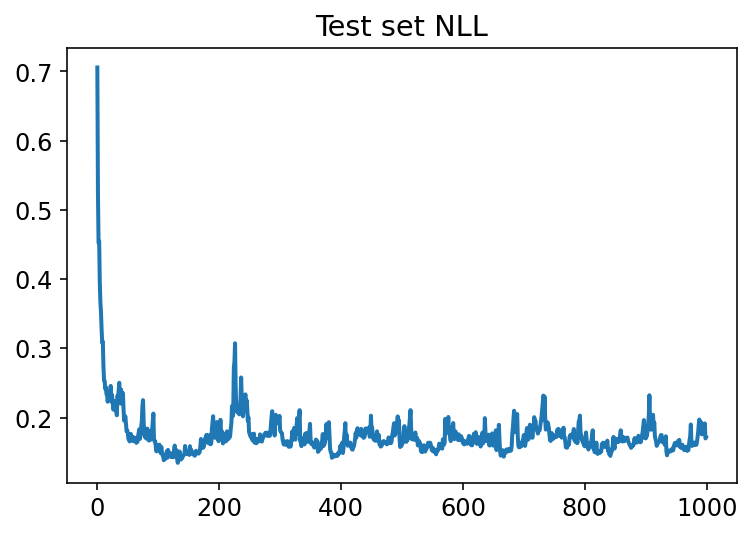

In [31]:
fig, ax = plt.subplots()
ax.plot(output_67_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 2.4 Digits 8 & 9

In [92]:
X_89_train, y_89_train = train_set_by_digit_pair['89']
X_89_test, y_89_test = test_set_by_digit_pair['89']

In [93]:
test_89_kwargs = {"X_test": X_89_test, "y_test": y_89_test, "apply_fn": mlp_apply_fn}

In [94]:
bel_89_fcekf, output_89_fcekf = fcekf_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_fcekf, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/11800 [00:00<?, ?it/s]

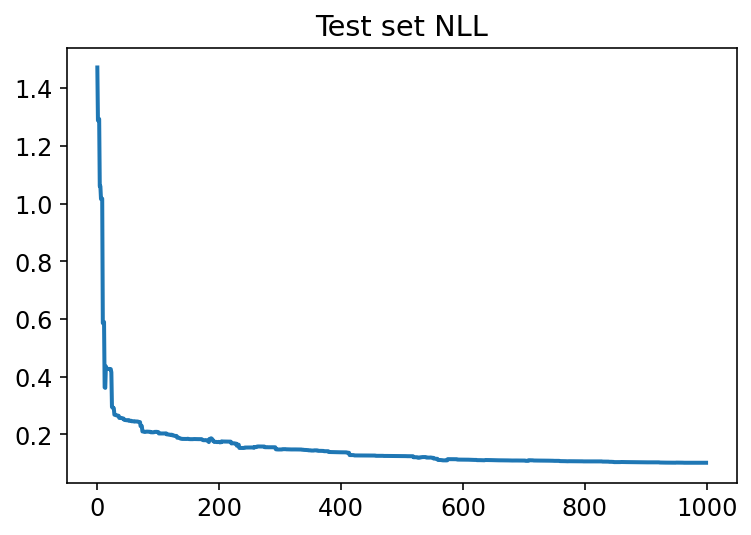

In [95]:
fig, ax = plt.subplots()
ax.plot(output_89_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

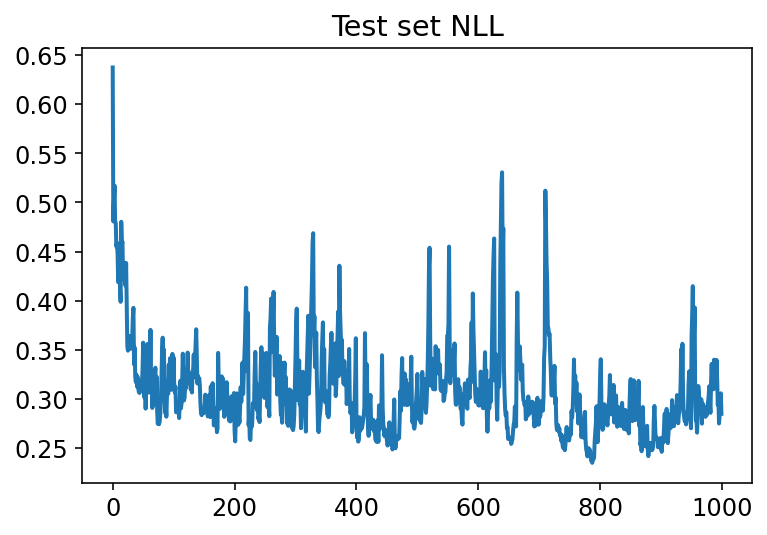

In [35]:
fig, ax = plt.subplots()
ax.plot(output_89_fcekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

# 3. FDEKF

## 3.1 Hyperparameter Tuning

In [36]:
fdekf_optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, nll_callback, 'fdekf',
    emission_mean_function, emission_cov_function
)

In [37]:
%%time
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=20,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.6934   | 0.9169    | -2.057    |
| 2         | -0.6957   | 0.265     | -1.084    |
| 3         | -0.6953   | 0.918     | -0.8632   |
| 4         | -0.6932   | 0.728     | -3.698    |
| 5         | -0.6932   | 0.9118    | -3.696    |
| 6         | -0.6932   | 0.7664    | -3.692    |
| 7         | -0.6933   | 0.1223    | -3.07     |
| 8         | -0.6932   | 0.8401    | -3.609    |
| 9         | -0.6941   | 0.06991   | -1.834    |
| 10        | -0.6937   | 0.5848    | -2.094    |
| 11        | -0.6946   | 0.6772    | -1.564    |
| 12        | -0.6932   | 0.4389    | -3.395    |
| 13        | -0.6934   | 0.5706    | -2.601    |
| 14        | -0.6969   | 0.8611    | -0.826    |
| 15        | -0.6932   | 0.1058    | -4.698    |
| 16        | -0.6961   | 0.5969    | -1.038    |
| 17        | -0.6935   | 0.2264    | -2.324    |
| 18        | -0.6933   | 0.1361    | -3.139    |


In [38]:
fdekf_hparams = hp_ekf.get_best_params(n_params, fdekf_optimizer, method="fdekf")
fdekf_hparams.pop('emission_cov_function')
fdekf_estimator = hp_ekf.build_estimator(flat_params, fdekf_hparams, None, mlp_apply_fn, method="fdekf",
                                         emission_mean_function=emission_mean_function,
                                         emission_cov_function=emission_cov_function)

In [39]:
bel_fdekf = fdekf_estimator.init_bel()

## 3.2 Digits 4 & 5

In [40]:
bel_45_fdekf, output_45_fdekf = fdekf_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_fdekf, progress_bar=True, **test_45_kwargs
)

  0%|          | 0/11263 [00:00<?, ?it/s]

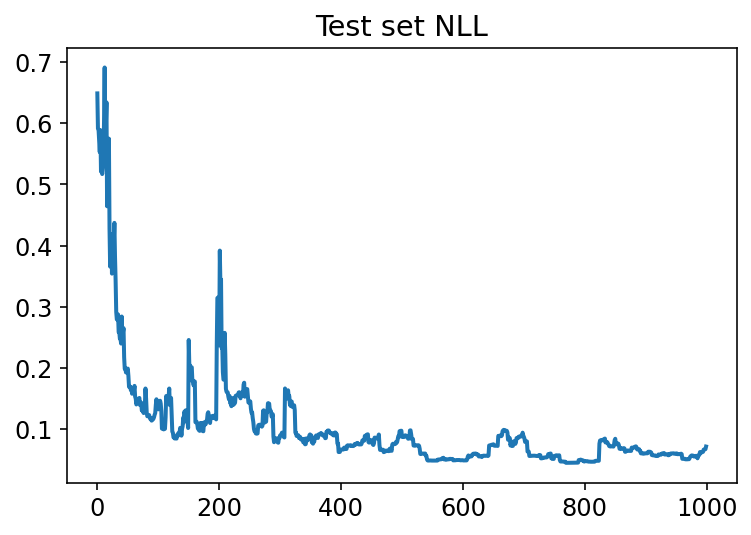

In [41]:
fig, ax = plt.subplots()
ax.plot(output_45_fdekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 3.3 Digits 6 & 7

In [42]:
bel_67_fdekf, output_67_fdekf = fdekf_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_fdekf, progress_bar=True, **test_67_kwargs
)

  0%|          | 0/12183 [00:00<?, ?it/s]

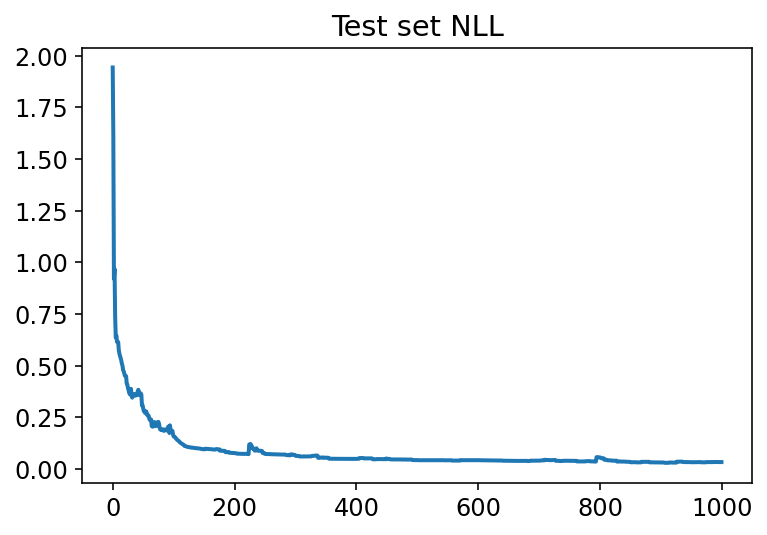

In [43]:
fig, ax = plt.subplots()
ax.plot(output_67_fdekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 3.4 Digits 8 & 9

In [44]:
bel_89_fdekf, output_89_fdekf = fdekf_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_fdekf, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/11800 [00:00<?, ?it/s]

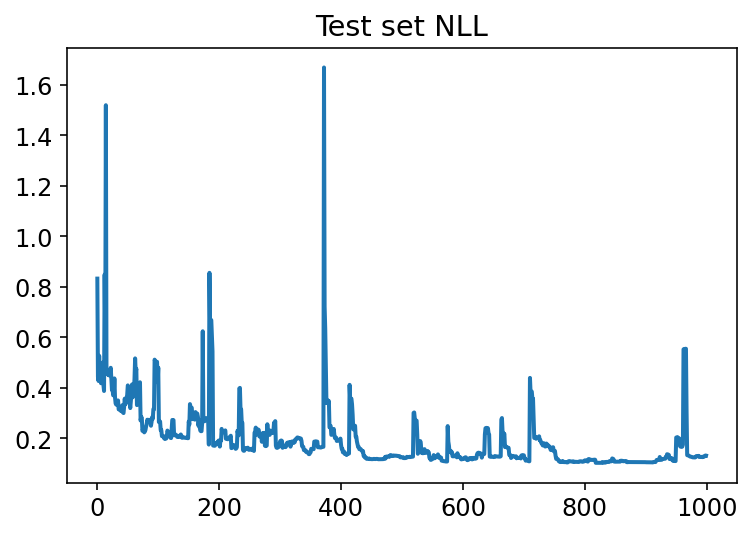

In [45]:
fig, ax = plt.subplots()
ax.plot(output_89_fdekf['nll_test'][:1000]);
ax.set_title('Test set NLL');

# 4. Orth-LoFi

## 4.1 Hyperparameter Tuning

In [96]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

orth_lofi_optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, nll_callback, method,
    emission_mean_function, emission_cov_function,
)

In [97]:
%%time
orth_lofi_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.2175   | 0.9917    | -2.057    |
| 2         | -0.6957   | 0.9265    | -1.084    |
| 3         | -0.2094   | 0.9918    | -0.8632   |
| 4         | -0.6932   | 0.9728    | -3.698    |
| 5         | -0.5533   | 0.9912    | -3.696    |
| 6         | -0.6932   | 0.9766    | -3.692    |
| 7         | -0.6931   | 0.9122    | -3.07     |
| 8         | -0.6932   | 0.984     | -3.609    |
| 9         | -0.6952   | 0.907     | -1.834    |
| 10        | -0.6933   | 0.9585    | -2.094    |
| 11        | -0.261    | 0.9948    | -0.8419   |
| 12        | -0.1969   | 0.9942    | -2.024    |
| 13        | -0.2054   | 0.9932    | -2.023    |
| 14        | -0.4929   | 0.9359    | -0.8685   |
| 15        | -0.2295   | 0.9936    | -0.9121   |
| 16        | -0.2279   | 1.0       | -0.9774   |
| 17        | -0.4983   | 0.9369    | -0.9658   |
| 18        | -0.2654   | 0.9979    | -0.7334   |


In [98]:
orth_lofi_hparams = hp_lofi.get_best_params(n_params, orth_lofi_optimizer)
orth_lofi_hparams.pop('emission_cov_function')
orth_lofi_estimator = hp_lofi.build_estimator(flat_params, orth_lofi_hparams, params_lofi,
                                              mlp_apply_fn, method, emission_mean_function,
                                              emission_cov_function,)

In [99]:
bel_orth_lofi = orth_lofi_estimator.init_bel()

## 4.2 Digits 4 & 5

In [100]:
bel_45_orth_lofi, output_45_orth_lofi = orth_lofi_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_orth_lofi, progress_bar=True, **test_45_kwargs
)

  0%|          | 0/11263 [00:00<?, ?it/s]

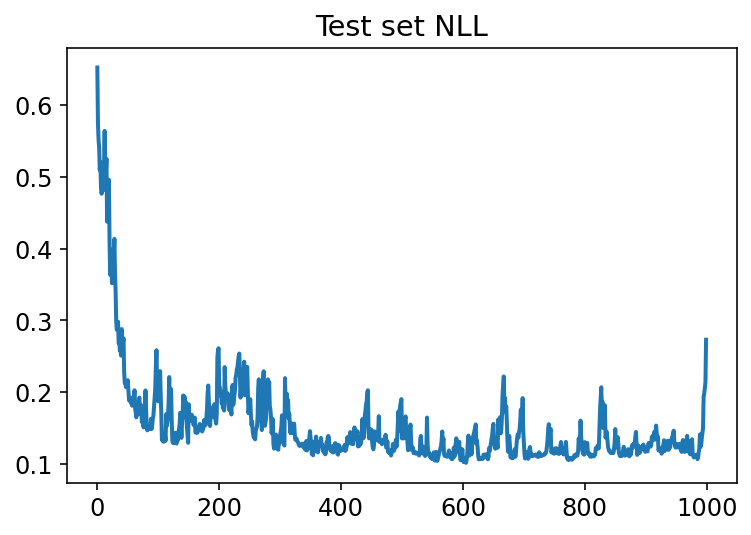

In [101]:
fig, ax = plt.subplots()
ax.plot(output_45_orth_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

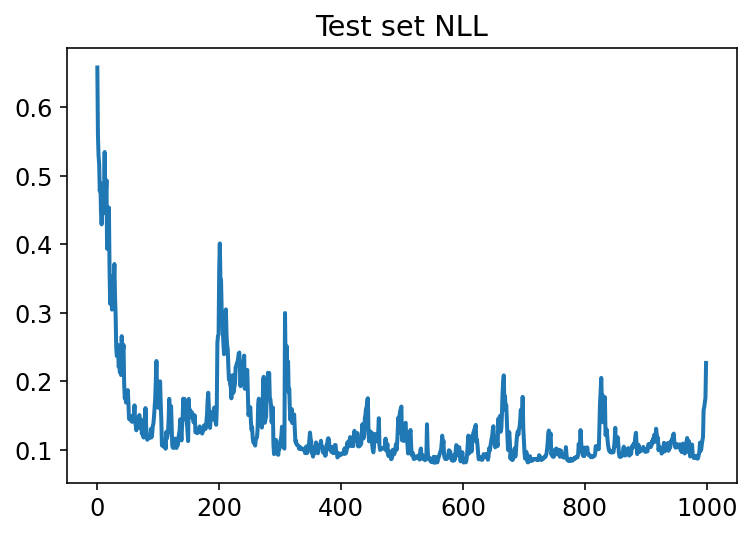

In [51]:
fig, ax = plt.subplots()
ax.plot(output_45_orth_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 4.3 Digits 6 & 7

In [102]:
bel_67_orth_lofi, output_67_orth_lofi = orth_lofi_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_orth_lofi, progress_bar=True, **test_67_kwargs
)

  0%|          | 0/12183 [00:00<?, ?it/s]

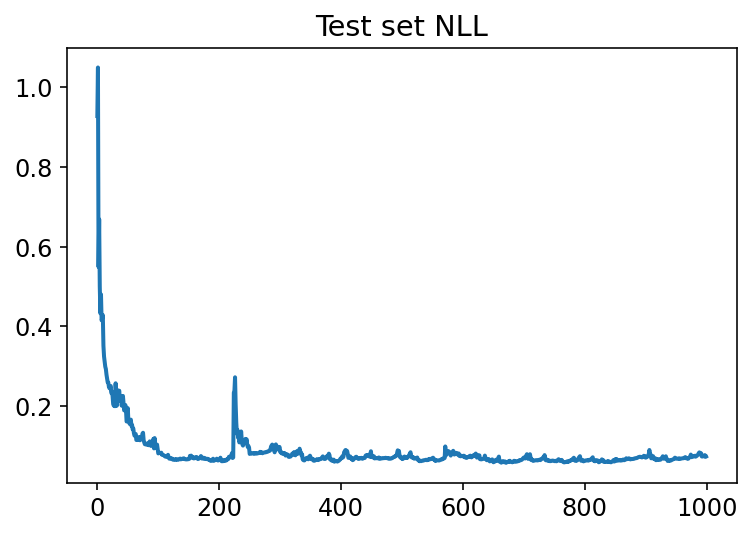

In [103]:
fig, ax = plt.subplots()
ax.plot(output_67_orth_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

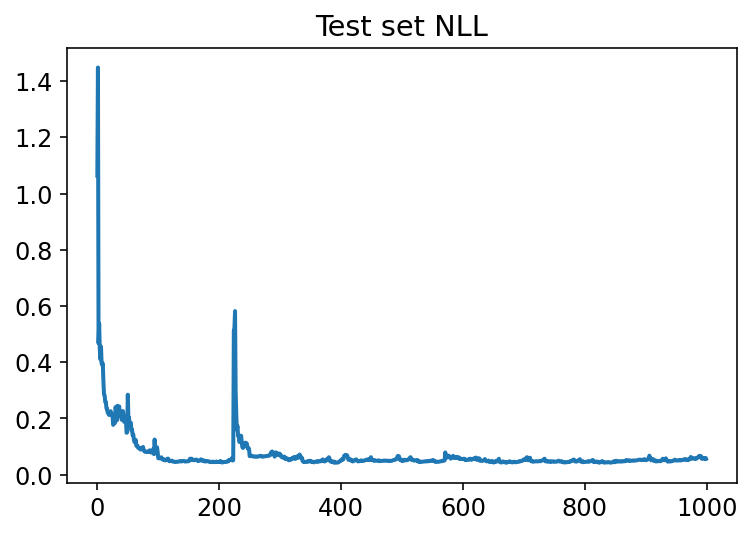

In [53]:
fig, ax = plt.subplots()
ax.plot(output_67_orth_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 4.4 Digits 8 & 9

In [104]:
bel_89_orth_lofi, output_89_orth_lofi = orth_lofi_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_orth_lofi, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/11800 [00:00<?, ?it/s]

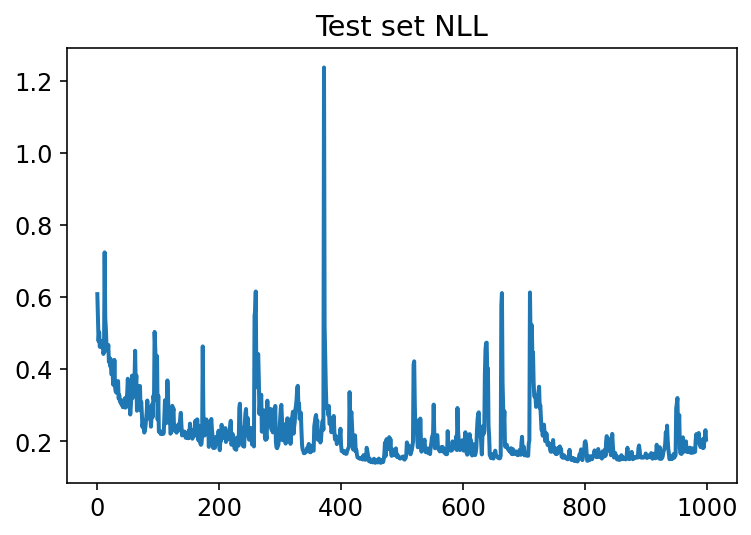

In [105]:
fig, ax = plt.subplots()
ax.plot(output_89_orth_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

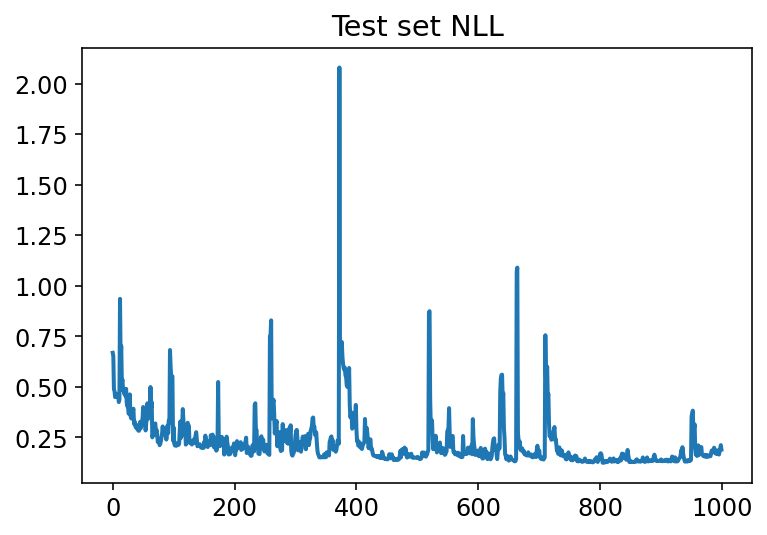

In [55]:
fig, ax = plt.subplots()
ax.plot(output_89_orth_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

# 5. Full-LoFi

## 5.1 Hyperparameter Tuning

In [106]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

full_lofi_optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, nll_callback, method,
    emission_mean_function, emission_cov_function,
)

In [107]:
%%time
full_lofi_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.3092   | 0.9917    | -2.057    |
| 2         | -0.6944   | 0.9265    | -1.084    |
| 3         | -0.2628   | 0.9918    | -0.8632   |
| 4         | -0.6932   | 0.9728    | -3.698    |
| 5         | -0.6767   | 0.9912    | -3.696    |
| 6         | -0.6932   | 0.9766    | -3.692    |
| 7         | -0.6932   | 0.9122    | -3.07     |
| 8         | -0.6932   | 0.984     | -3.609    |
| 9         | -0.6936   | 0.907     | -1.834    |
| 10        | -0.6932   | 0.9585    | -2.094    |
| 11        | -0.2497   | 0.9999    | -0.8312   |
| 12        | -0.1828   | 0.9993    | -1.994    |
| 13        | -0.2559   | 0.9933    | -0.864    |
| 14        | -18.12    | 1.0       | -0.7161   |
| 15        | -0.6944   | 0.9084    | -1.273    |
| 16        | -0.6932   | 0.9377    | -3.259    |
| 17        | -0.6932   | 0.9038    | -3.437    |
| 18        | -0.195    | 1.0       | -1.672    |


In [58]:
full_lofi_hparams = hp_lofi.get_best_params(n_params, full_lofi_optimizer)
full_lofi_hparams.pop('emission_cov_function')
full_lofi_estimator = hp_lofi.build_estimator(flat_params, full_lofi_hparams, params_lofi,
                                              mlp_apply_fn, method, emission_mean_function,
                                              emission_cov_function,)

In [59]:
bel_full_lofi = full_lofi_estimator.init_bel()

## 5.2 Digits 4 & 5

In [60]:
bel_45_full_lofi, output_45_full_lofi = full_lofi_estimator.scan(
    X_45_train, y_45_train, callback=eval_callback, bel=bel_full_lofi, progress_bar=True, **test_45_kwargs
)

  0%|          | 0/11263 [00:00<?, ?it/s]

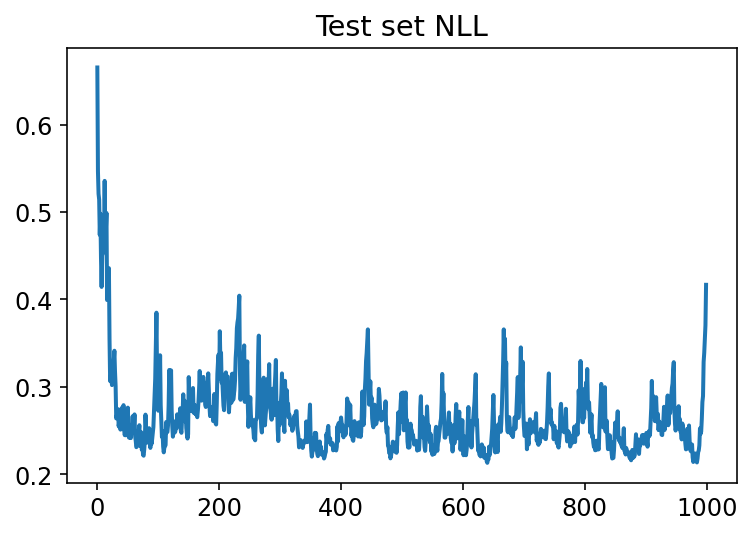

In [61]:
fig, ax = plt.subplots()
ax.plot(output_45_full_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 5.3 Digits 6 & 7

In [62]:
bel_67_full_lofi, output_67_full_lofi = full_lofi_estimator.scan(
    X_67_train, y_67_train, callback=eval_callback, bel=bel_45_full_lofi, progress_bar=True, **test_67_kwargs
)

  0%|          | 0/12183 [00:00<?, ?it/s]

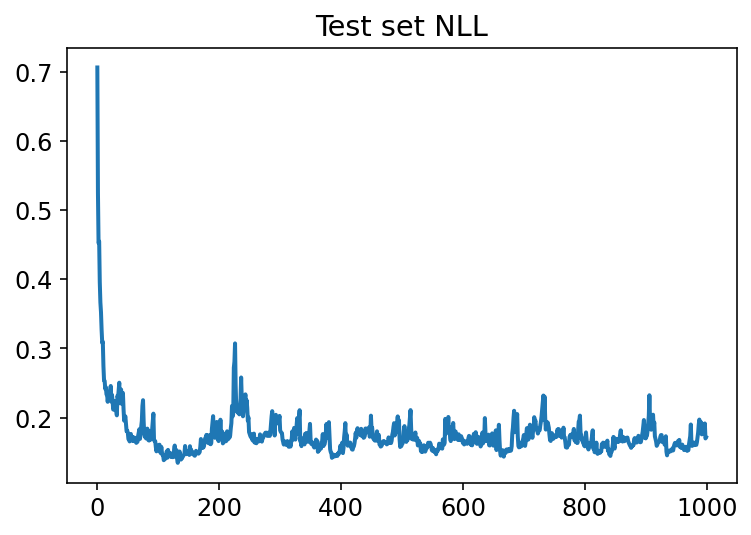

In [63]:
fig, ax = plt.subplots()
ax.plot(output_67_full_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

## 5.4 Digits 8 & 9

In [64]:
bel_89_full_lofi, output_89_full_lofi = full_lofi_estimator.scan(
    X_89_train, y_89_train, callback=eval_callback, bel=bel_67_full_lofi, progress_bar=True, **test_89_kwargs
)

  0%|          | 0/11800 [00:00<?, ?it/s]

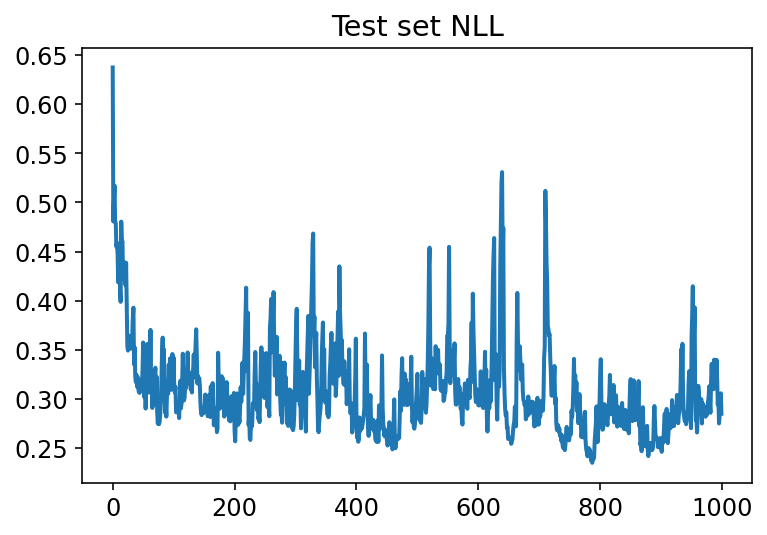

In [65]:
fig, ax = plt.subplots()
ax.plot(output_89_full_lofi['nll_test'][:1000]);
ax.set_title('Test set NLL');

# 6. Model Comparison

## Digits 4 & 5

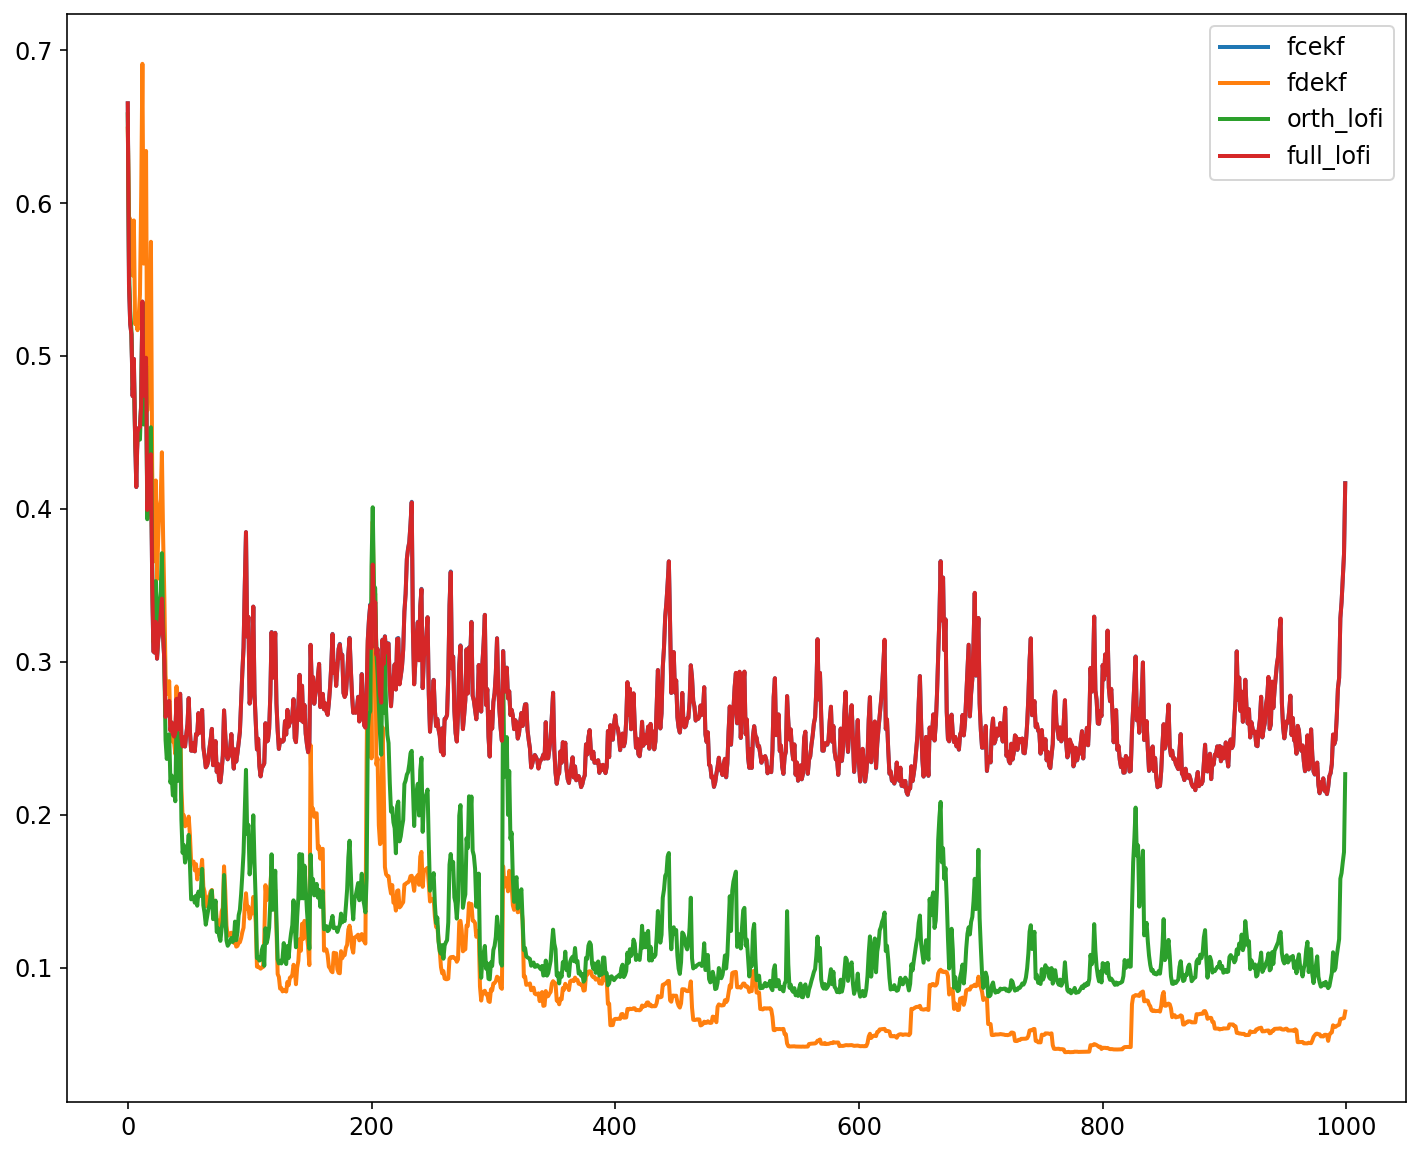

In [72]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(output_45_fcekf['nll_test'][:1000], label='fcekf')
ax.plot(output_45_fdekf['nll_test'][:1000], label='fdekf')
ax.plot(output_45_orth_lofi['nll_test'][:1000], label='orth_lofi')
ax.plot(output_45_full_lofi['nll_test'][:1000], label='full_lofi');
ax.legend();

## Digits 6 & 7

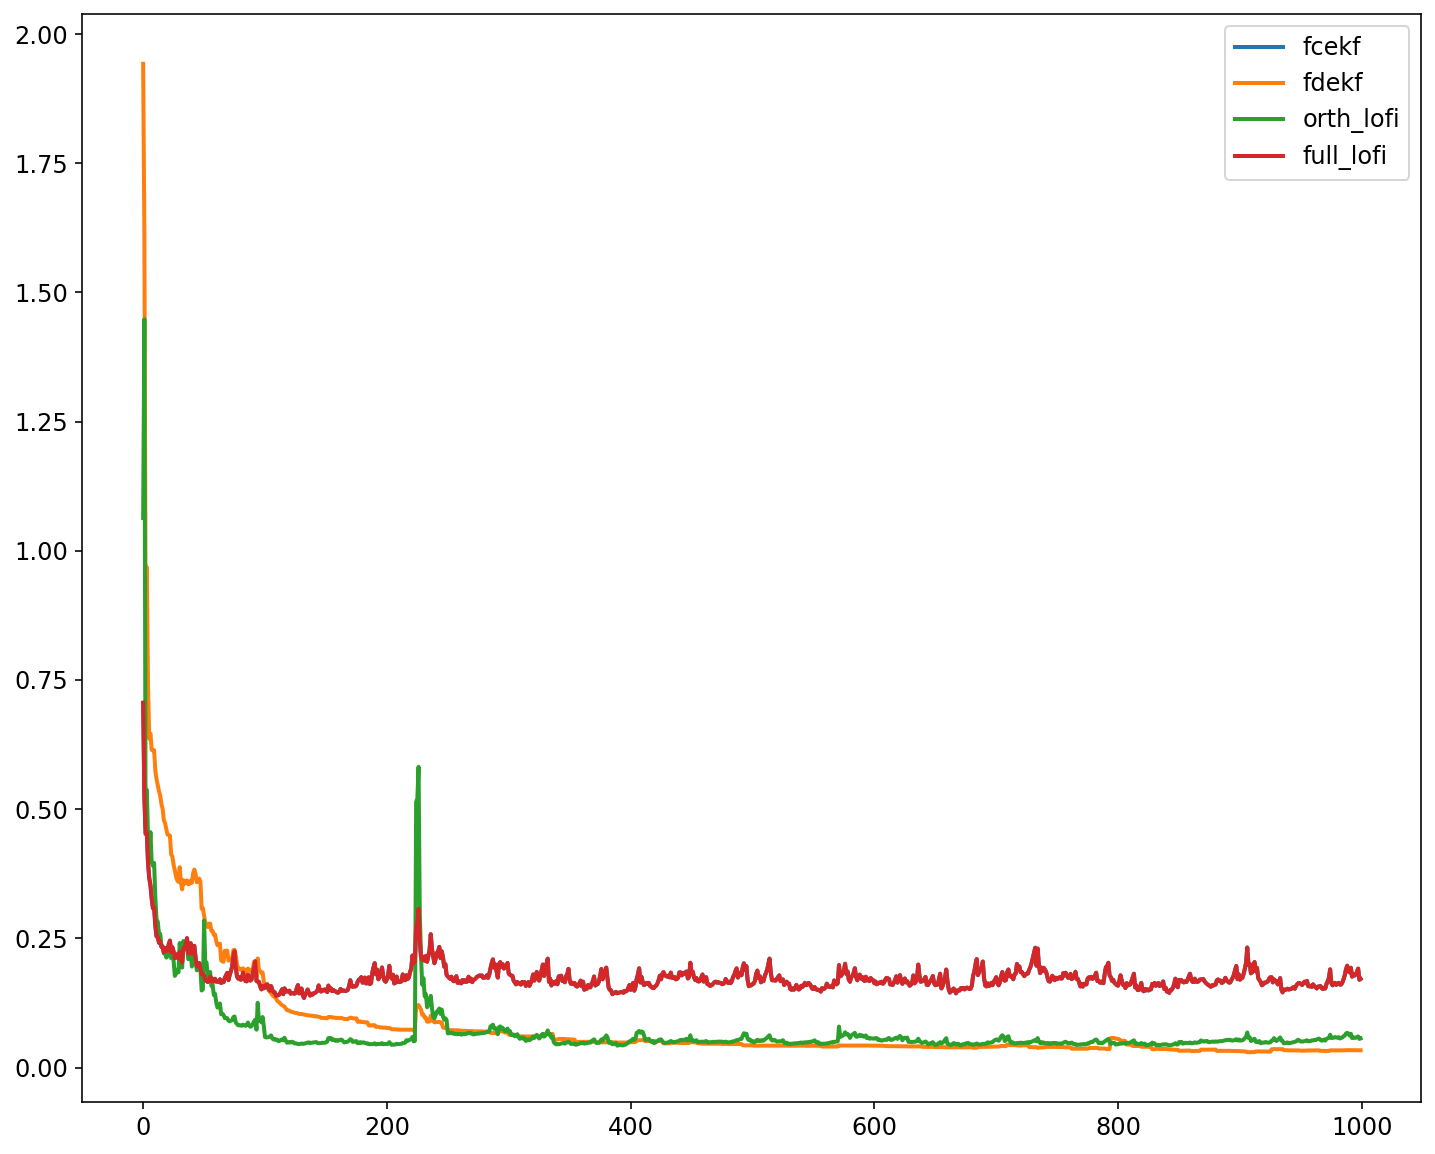

In [73]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(output_67_fcekf['nll_test'][:1000], label='fcekf')
ax.plot(output_67_fdekf['nll_test'][:1000], label='fdekf')
ax.plot(output_67_orth_lofi['nll_test'][:1000], label='orth_lofi')
ax.plot(output_67_full_lofi['nll_test'][:1000], label='full_lofi')
ax.legend();

## Digits 8 & 9

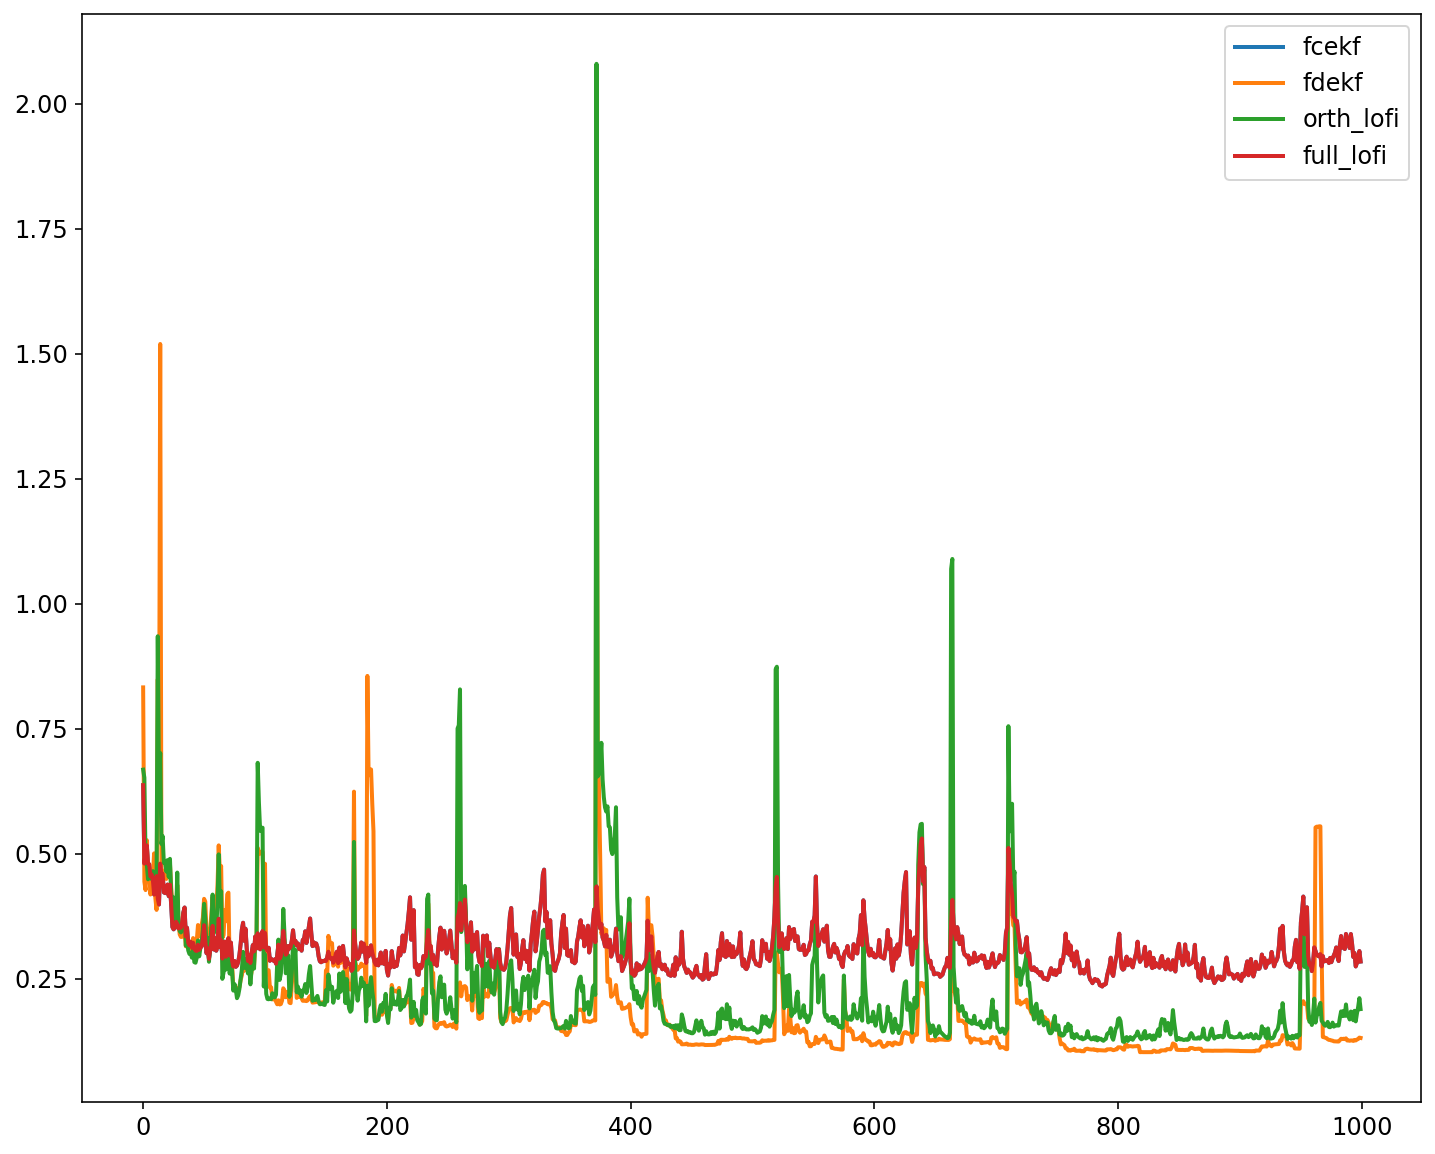

In [74]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(output_89_fcekf['nll_test'][:1000], label='fcekf')
ax.plot(output_89_fdekf['nll_test'][:1000], label='fdekf')
ax.plot(output_89_orth_lofi['nll_test'][:1000], label='orth_lofi')
ax.plot(output_89_full_lofi['nll_test'][:1000], label='full_lofi')
ax.legend();